<a href="https://colab.research.google.com/github/ronen-halevy/ai-notebooks/blob/main/image-classification/Building_Tensorflow_Image_Input_Pipeline_Part_4_Using_TFDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Building Tensorflow Image Input Pipeline Part 1-With TFDS
---



## Introduction
---

The Input Data Pipeline is the preprocessing stage of the Neural Network. It operates in an **`ETL`** (**E**xtract, **T**ransform, **L**oad) pipelined process, as depicted in the figure which follows.


**`Input Data Pipeline`:**


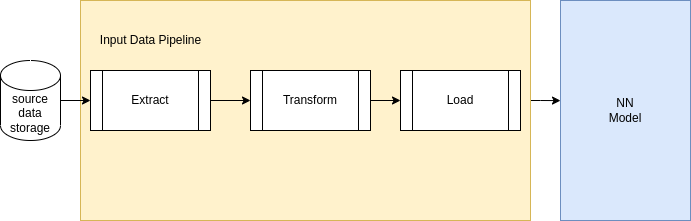

### **Input Data Pipeline Outlines**
---


The **Extract** block fetches data from input data source, which in case of Image Data Networks are most likely data files, arranges them as dataset memory objects in local memory.

The **Transform** block, naturally, transformd the data to create an efficient input data set. Most of the transforms are regarded `Performance Transforms` as they format the data to achieve better compute performance.


The **Load** block transfers the data to the Network's input layer. 



### **Commonly Used Data Transform**
---


- **Image Decoding** - decode either from jpeg or any coding format.
- **Data batching** - batches of data, be it image data or not, are required for an efficient parralelized process in general, and speciffically better exploits GPUs parralelism capabilities.
.
- **Resize** - Networks require uniform sized images only. Since source data images are mostly uniform in size, a `resize` operation is mandatory. Now, which is size to resize to? The answer is not always straight forward and definite. There are tradeoffs such as a tradeoff between details preservation vs compution and memory load. Anyway, we will set dimenssions such that after downsizing both height and width ramain integrer.



- **Normalize** (or better say scale) input data to the range [0,1]. A standardized  data range for all input data is essential for a better model Performance. 

- **Caching** of input data to avoid reloading at each epoch fitting cycle. Large datasets which do not fit in memory, should not be cached.

- **Shuffling** - which randomized the data loading sequence order.
- **Prefetch** which supports concurrent data prefetching and data processing.
- **Data Augmentation** which expands training dataset, increases the diversity of training set, by applying transformations, such as image rotation, flips, shifts.


### **About the series of posts**

This page is part of a series posts about **Building An Tensorflow Image Input Pipeline**.

Each post of this series presents one approach for the creation of an input image data pipeline, each uses a different set of APIs.

They differ in aspects such as level of integration (some are more integrated convinience api while others are less integrated but sometimes more flexible), and also differ in terms of efficiency and performance, (the `ImageGenerator` approach proves to be less performant)

Still, all approaches create a tensorflow dataset object which is an itegrated part of the Neural Netork Graph, along with the NN model, thus providing a smooth data integration throughout the process.

### Description of the Posts Contents

Each of the posts illustrates the creation of the input data pipeline in the context of a data classification example, using various data sources: `rock-paper-scissors`, `flowers`, `flowers` and `horses or humans`


### List of the series posts:
---

The posts of this series are: 


- **Building Tensorflow Image Input Pipeline Part 1**: Using tf.data()

- [**Building Tensorflow Image Input Pipeline Part 2**: Using Keras Utils](https://colab.research.google.com/drive/1s3EdMO2uMWQMtqsPxIZOS-cvA4QqfMls#scrollTo=gpz8q177vSBj&uniqifier=2)

- **Building Tensorflow Image Input Pipeline Part 3**: Using ImageGenerator()
- **Building Tensorflow Image Input Pipeline Part 4**: Using TFDS()


Each of the posts illustrates the creation of the dataset within an image classification example. 

Let's go dive into the code!


##**About data pipeline Creation with TDFS**
---

TDFS module provides integrated convinience apis for an easy process. Yet, it fits Tensorflow Datasets only.



## 1. Import Packages
---

In [96]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import random

In [97]:
batch_size = 32
image_height = 160
image_width = 160

## 2. Download the data
---
Here we download the dataset using ***tfds.load***, a convinience method supported by Tensorflow's Catalog Datasets. 

The method supports many attributes which make it setup all dataset transformation within this single method.

Still, here we'll set data transformation, except the dataset split, by seperate transform functions whci follow.

**Notes on some of the method's attributes:**

- **name** - Name of the dataset, as it is refferenced in the Tensorflow Dataset Catalog.

- **split** - Determines which split of the data to load, and defines slicing of the splits.

- **with_info** - (Bool, Default=False) Returns dataset info

- **as_supervised** - (Bool, Default=False). If True, dataset will have 2 tupple structure (input, label). If False, dataset will have a dictionary with all the features.









In [98]:
(train_ds, val_ds, test_ds), info = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 
    'train[80%:90%]',
    'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

The above method return not only the various dataset splits, but also info metadata dataset_file point on downloaded file:

In [99]:
print(info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



In [100]:
num_classes = info.features['label'].num_classes
print('num_classes: ', num_classes)
class_names = info.features['label'].names
print('class_names: ',class_names)

num_classes:  5
class_names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


***Visualization*** - take a brief look at randomly selected images 

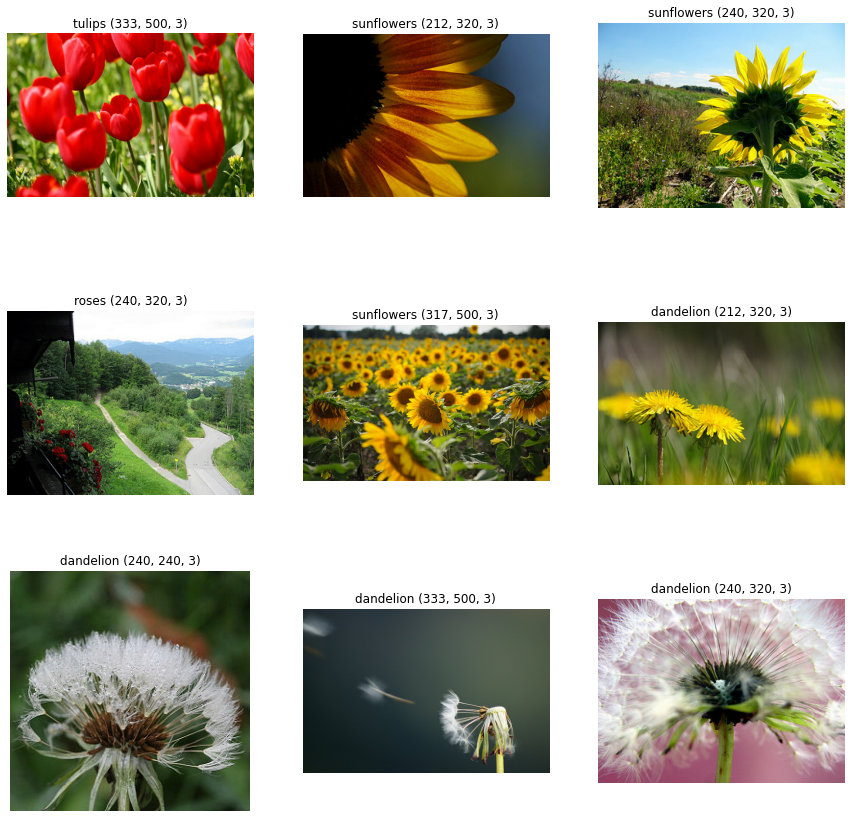

In [101]:
get_label_name = info.features['label'].int2str
plt.figure(figsize=(15, 15))
cnt = 0
for image, label in train_ds.take(9):
  cnt += 1
  ax = plt.subplot(3, 3, cnt)
  ax.imshow(image)
  _ = ax.set_title(get_label_name(label)+ ' ' + str(image.shape))
  _ = ax.axis("off")

## 3. Create the Input Data Pipeline 
---

####**Some Values Setup**


- **batch size**: A batch size of 32 is a good starting point. There's a trade-off here, were a too small batch size might lead to a too slow processing due to lacking vectorization. A too large batch might leads to low accuracy and thus longer training time.


In [102]:
batch_size = 32


- **image_height**, **image_width**: The are tradeoffs in setting the input dimenssions: keeping details vs process load. Anyway, since source data image is mostly none size uniform, resizing is essential. Since the NN deployed here has 5 pooling modules, which reduce size overall by 32, the size was set to a multiply of 32.

In [103]:
image_height = 160
image_width = 160

**A Note on Selection of Image Size**

Following the `Introdcution's` notes on resize operation, with 3 pooling modules each downsizes by 2, and altogether downsize the input image by a factor of 8 in both the height and width domenssions, the selected new size is set to a multiply of 8.



In [104]:
def format_image(image, label):
    image = tf.image.resize(image, [image_height, image_width])
    return  image, label

train_ds = train_ds.map(format_image)
val_ds = val_ds.map(format_image)
test_ds = test_ds.map(format_image)

In [105]:
train_ds.element_spec

(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

## 4. Configure Dataset for Performance
---

**Configure the Dataset for Performance**

Some essential data transformations were already performed by `image_dataset_from_directory`. 

That includes **`batching`**, **`image format decoding`**, **`splitting`** and `resizing`.

Those transformation were essential for the execution of the network.


Next transormations are needed to improve performance:


- **cache** -  keeps the images in memory after they're loaded off disk during 
the first epoch.

- **shuffle** - fills a buffer with buffer_size elements, then randomly samples elements from this buffer. The sampled elements are replaced by new dataset elements as depicted in the diagram below. 

- **prefetch** -  overlaps data preprocessing and model execution while training. (The tf.data.AUTOTUNE parameter defines a dynamic tuning of the number of prefetched data elements. The number depends on the number of batches consumed in a single step, i.e. on parallelism extent). In case both **perfecth** and **shuffle** are set, the shuffle buffer should be greater than or equal to the full size of the dataset.

- **normalization** - standardizes the inputs to the range [0,1], which improves performance.


- **augmentation** - expands training dataset, increases the diversity of training set, by applying transformations, such as image rotation, flips, shifts, and shear.




In [106]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=tf.data.experimental.cardinality(ds))
  ds = ds.batch(batch_size, drop_remainder=False)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

**Data Augmentation** - Expand training dataset size

In [107]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_height,
                                  image_width,
                                  3)),
    layers.RandomRotation(0.1, fill_mode="nearest",),
    layers.RandomZoom(0.1),
  ]
)

**Demonstrate Augmentation Visualization**: 

Here's how the augmented images look like

- Original image is at upper left

- 8 randomly augmented images. 


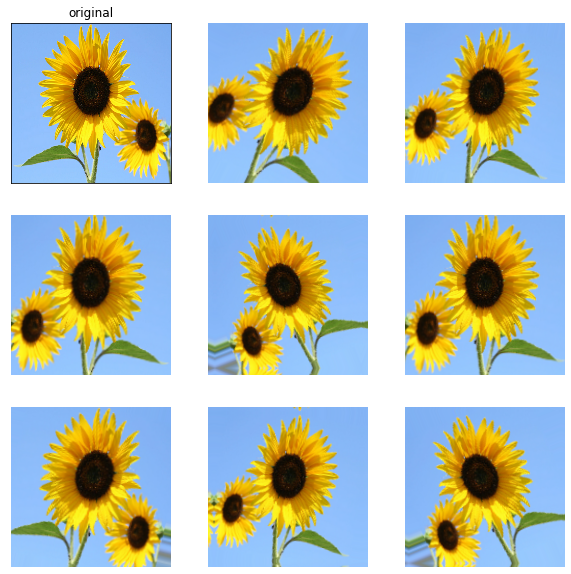

In [110]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  image = images[random.randint(0, len(images)-1)]
  ax = plt.subplot(3, 3, 1)
  ax.set_title('original')
  plt.imshow(image/255)
  ax.set_xticks([])
  ax.set_yticks([])
  for i in range(8):
    augmented_images = data_augmentation((tf.expand_dims(image, axis=0, name=None)))
    ax = plt.subplot(3, 3, i + 2)
    plt.imshow(augmented_images[0].numpy().astype("float32")/255)
    plt.axis("off")

Set Augmentation to training dataset

In [64]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

**Normalize the data**

Standardizes the inputs. This is often integrated within the model, but can also be set on the dataset like so:

In [65]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

**Present some sample images of the final train dataset:**

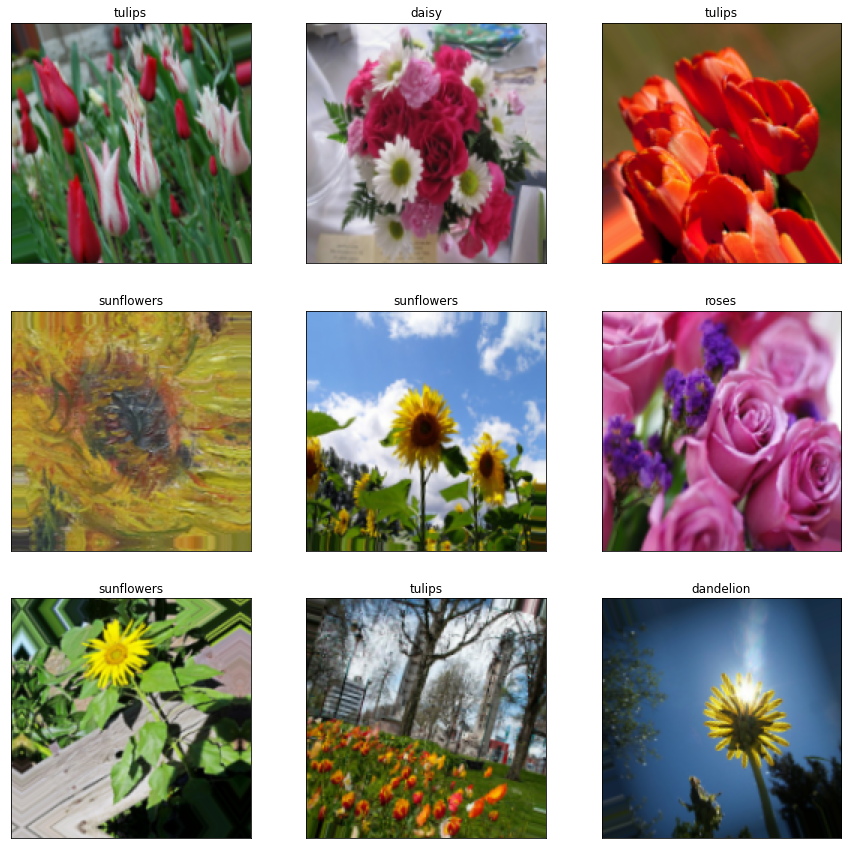

In [66]:
get_label_name = info.features['label'].int2str

batch = train_ds.take(1)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
cnt=0
itr = batch.as_numpy_iterator()
images, labels = itr.next()
for idx in range(9):
  cnt +=1
  ax = fig.add_subplot(3, 3, cnt)
  ax.imshow(images[idx])
  
  ax.set_title(get_label_name(labels[idx]))
  labels
  ax.set_xticks([])
  ax.set_yticks([])


**Present a bunch of sample images of the final train dataset:**


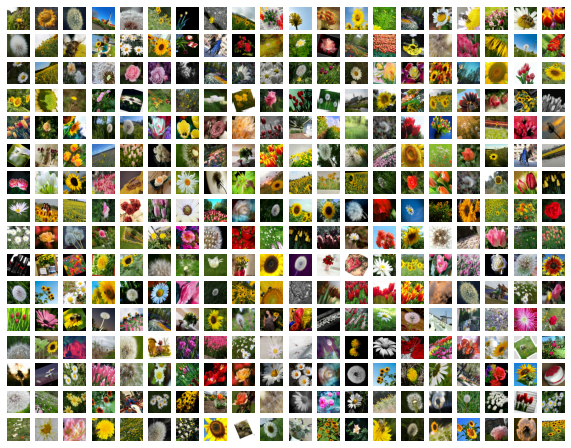

In [17]:
plt.figure(figsize=(10, 10))
batches_in_loop = 10
for j in range(batches_in_loop):
  image_batch, _ = next(iter(train_ds))
  for i in range(32):
    ax = plt.subplot(20, 20, j*32 + i + 1)
    plt.imshow(image_batch[i])
    plt.axis("off")

## 5. Set the model
---

The model consists of 5 layers:
- It begins with 3 convolution blocks, each followed by a max pooling module.

- Then, after flattening the data, convolution blocks are followed by 2 dense layers: 
 - A 128 units dense layer
 - The output layer, with 3 units according to the 3 output classes, i.e.rock, paper, scissors.


In [18]:
# num_classes = 5
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

<a name='5'></a>
## 6. Compile the Model
---

- **optimizer** `adam` - a commonly used stochastic adaptive optimizer.  
- **loss function** `SparseCategoricalCrossentropy` - commonly used for image classification with more than 2 classes
- **from_logits**=True, which indicates to the loss function that the NN output is not normalized, i.e. there is no softmax function at the output. 

(BTW, excluding the softmax function from the model, is considered to be a more numerically stable implementation. The softamx is then added by the loss function module.)


In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 7. Train the model
---

**Set an Early Stopping Callback:**

The EarlyStopping callback in invoked after each epoch. 

Callback's Functionality is like so:

- It Stops training if the monitored metric no improvements 
- `patience` is the number of epochs with no improvement after which training will be stopped.

- After waiting `patience` epochs, the best weights among all epochs results will be restored.



In [20]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=0, 
                                patience=10, 
                                verbose=1, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=True)

Now do the fit,  with early_stop_cb.

In [21]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop_cb],
)

Epoch 1/50
92/92 [==============================] - 24s 161ms/step - loss: 1.7266 - accuracy: 0.4710 - val_loss: 3.5844 - val_accuracy: 0.2507
Epoch 2/50
92/92 [==============================] - 15s 167ms/step - loss: 1.1200 - accuracy: 0.5668 - val_loss: 3.3940 - val_accuracy: 0.2698
Epoch 3/50
92/92 [==============================] - 15s 159ms/step - loss: 1.0451 - accuracy: 0.6005 - val_loss: 1.6317 - val_accuracy: 0.4005
Epoch 4/50
92/92 [==============================] - 15s 160ms/step - loss: 0.9710 - accuracy: 0.6202 - val_loss: 1.3055 - val_accuracy: 0.4959
Epoch 5/50
92/92 [==============================] - 15s 159ms/step - loss: 0.9178 - accuracy: 0.6369 - val_loss: 0.9843 - val_accuracy: 0.6022
Epoch 6/50
92/92 [==============================] - 15s 161ms/step - loss: 0.8705 - accuracy: 0.6638 - val_loss: 1.0158 - val_accuracy: 0.6076
Epoch 7/50
92/92 [==============================] - 15s 160ms/step - loss: 0.8371 - accuracy: 0.6764 - val_loss: 0.8917 - val_accuracy: 0.6485

## 8. Display model summary
---

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 158, 158, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 77, 77, 32)       128       
 hNormalization)                                                 
                                                      

## 9 Visualize training results
---

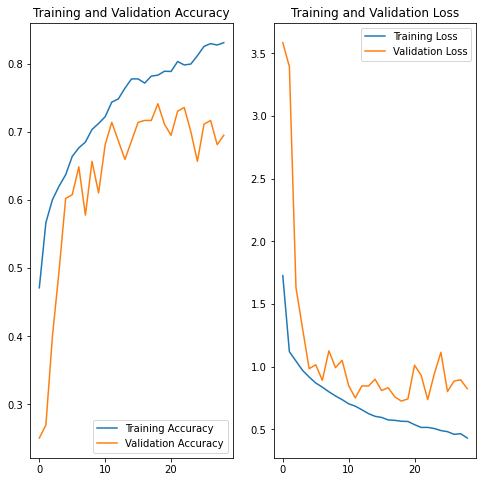

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Notes on Training Results**

Obviously, it would be possible to reach better accuracy and loss by optimizing the model.

The goal of this post was to present the the building of the dataset, and not necasarily achieve optimal network output.

A much better results are demonstrated with more optimized network in a dedicated post TBD!!



## 10. Inference
---

With the trained model at hand, let's run inference over the test dataset.


- **Run Prediction over The Test Dataset** - run `model.predict` and present output for some test dataset images
- **Find Accuracy and Loss** - run model.evaluate over the test dataset.

#### **Run Prediction over The Test Dataset**

- Successful  classification are colored `blue`
- False classification are colored `red`


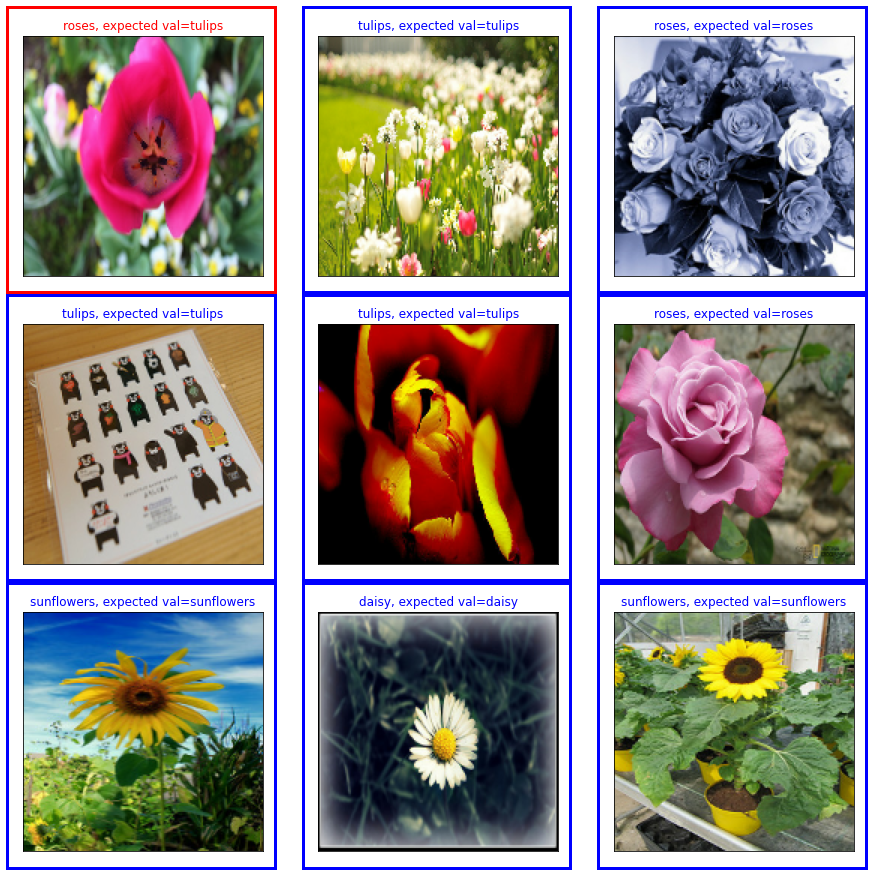

In [27]:
def plot_bounding_box(fig, ax, color):
  fig.canvas.draw()
  bbox = ax.get_tightbbox(fig.canvas.renderer)
  x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
  xpad = 0.05 * width
  ypad = 0.05 * height
  fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor=color, linewidth=3, fill=False))

batch = test_ds.take(1)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
cnt=0
itr = batch.as_numpy_iterator()
images, labels = itr.next()
for idx in range(9):
  result=model.predict(np.expand_dims(images[idx], axis=0))
  cnt +=1
  ax = fig.add_subplot(3, 3, cnt)
  ax.imshow(images[idx])
  ax.set_xticks([])
  ax.set_yticks([])
  error = True if class_names[np.argmax(result)] != class_names[labels[idx]] else False
  color = 'red' if error else 'blue'
  ax.set_title("{}, expected val={}".format(class_names[np.argmax(result)], class_names[labels[idx]]), color=color)  
  plot_bounding_box(fig, ax, color)


  

**Find Accuracy and Loss**
 
Run `model.evaluate` over the test dataset. It calculates loss and accuracy for this data.


In [28]:
results = model.evaluate(test_ds)
print(f'Test {model.metrics_names[0]}: {results[0]} , Test {model.metrics_names[1]}: {results[1]}')

12/12 [==============================] - 0s 7ms/step - loss: 0.6634 - accuracy: 0.7575
Test loss: 0.663360595703125 , Test accuracy: 0.7574931979179382
